# Model-based Large Language Model (LLM) Hallucination Detection


In [1]:
!pip install modelzoo-client[transformers]
!pip install openai
!pip install datasets
# !modelzoo auth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.1/789.1 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 10.6 MB/s eta 0:00:00
  Created wheel for names: filename=names-0.3.0-py3-none-any.whl size=803698 sha256=5885809304d2f7d5ee67baed6428fd1f6417ad76c42ab5d39b1f16734fbbc0bd
  Stored in directory: /root/.cache/pip/wheels/f1/bc/04/55ab9499ea02359ece8b02b4169ebb30aa52d82b84c13fc506
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4845 

In [2]:
from transformers import pipeline, set_seed, AutoModelForQuestionAnswering, AutoTokenizer, DistilBertTokenizer, DistilBertModel
from transformers.modeling_outputs import CausalLMOutput
import torch
import random
import os
import openai
import json
import numpy as np
from numpy import log2, prod, mean
import pandas as pd
from datasets import load_dataset
import math
import matplotlib.pyplot as plt
import spacy
from spacy import displacy

## First, focuse on Question-Ansering Task

Collect datasets from Hugging Face

In [3]:
# ELI5_dataset = load_dataset("Rahmaa/eli5_final")
WikiQA_dataset = load_dataset("wiki_qa")

Generating test split:   0%|          | 0/6165 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2733 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20360 [00:00<?, ? examples/s]

Dataset wiki_qa downloaded and prepared to /root/.cache/huggingface/datasets/wiki_qa/default/0.1.0/d2d236b5cbdc6fbdab45d168b4d678a002e06ddea3525733a24558150585951c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
key = list(WikiQA_dataset.keys())    # get keys in dataset
print("Available keys: {}".format(key))

WikiQA_df = WikiQA_dataset["train"].to_pandas()  # covert dataset to pandas df
# print(WikiQA_df.info())

# select the rows with true label
WikiQA_df = WikiQA_df[WikiQA_df['label'] == 1].reset_index()
WikiQA_df.head(10)

Available keys: ['test', 'validation', 'train']


,index,question_id,question,document_title,answer,label
0,3,Q1,how are glacier caves formed?,Glacier cave,A glacier cave is a cave formed within the ice...,1
1,75,Q16,how much is 1 tablespoon of water,Tablespoon,This tablespoon has a capacity of about 15 mL.,1
2,83,Q16,how much is 1 tablespoon of water,Tablespoon,In the USA one tablespoon (measurement unit) i...,1
3,84,Q16,how much is 1 tablespoon of water,Tablespoon,In Australia one tablespoon (measurement unit)...,1
4,98,Q17,how much are the harry potter movies worth,Harry Potter,The series also originated much tie-in merchan...,1
5,103,Q18,how a rocket engine works,Rocket engine,"A rocket engine, or simply ""rocket"", is a jet ...",1
6,128,Q21,how are cholera and typhus transmitted and pre...,Cholera,Transmission occurs primarily by drinking wate...,1
7,193,Q26,how did anne frank die,Anne Frank,"Anne Frank and her sister, Margot , were event...",1
8,214,Q28,how are aircraft radial engines built,Radial engine,The radial engine is a reciprocating type inte...,1
9,224,Q30,how deep can be drill for deep underwater,Deepwater drilling,Deepwater drilling is the process of oil and g...,1


In [5]:
# create the prompt
content_index = 0
question = WikiQA_df["question"][content_index]
answer = WikiQA_df["answer"][content_index]

print(F"Question: {question}  \n\nAnswer: {answer}")

Question: how are glacier caves formed?  

Answer: A glacier cave is a cave formed within the ice of a glacier .


In [6]:
# create the prompt
question = "Who is Jiayang Song and where does Jiayang Song live?"
# prompt = "Answer the following question in a short sentence, and then give the reasons separately: \n\nQuestion:" + question 
prompt = question 
print(prompt)

Who is Jiayang Song and where does Jiayang Song live?


## LLM from OpenAI API

In [ ]:
openai.api_key = ""

In [8]:
# model_list = []
# for model in openai.Model.list()["data"]:
#     model_list.append(model["root"])

# model_list = pd.DataFrame(model_list)
# print("Available models form OpenAI: {}".format(model_list.size))

Model endpoint compatibility



*   v1/chat/completions:  
    > gpt-4, gpt-4-0314, gpt-4-32k, gpt-4-32k-0314, gpt-3.5-turbo, gpt-3 5-turbo-0301
*   v1/completions
    > text-davinci-003, text-davinci-002, text-curie-001, text-babbage-001, text-ada-001, davinci, curie, babbage, ada



In [9]:
# send the request to the API and get the response
response = openai.Completion.create(
  model = "text-davinci-003",
  prompt = prompt,
  temperature = 0,
  logprobs = 5,
  presence_penalty = 0,
  frequency_penalty = 0,
  max_tokens = 100,
)

In [10]:
new_response = json.loads(str(response))["choices"][0]
text = new_response["text"]
top_logprobs = new_response["logprobs"]["top_logprobs"]

print("Text: {} \nResponse: {}\n".format(prompt, repr(text)))

Text: Who is Jiayang Song and where does Jiayang Song live? 
Response: '\n\nJiayang Song is a Chinese-American journalist and essayist. She is currently based in New York City.'



In [11]:

for index, content in enumerate(top_logprobs):
    for i in content:
        print("token {}: {:12s} - Prob: {:8f}".format(index, repr(i), math.exp(content[i])))
    print("\n")

token 0: '\n'         - Prob: 0.985338
token 0: '\n\n'       - Prob: 0.000047
token 0: ' '          - Prob: 0.014567
token 0: '  '         - Prob: 0.000043
token 0: '   '        - Prob: 0.000003


token 1: '\n'         - Prob: 0.999913
token 1: '\n\n'       - Prob: 0.000000
token 1: ' '          - Prob: 0.000008
token 1: ' Ji'        - Prob: 0.000000
token 1: 'J'          - Prob: 0.000077


token 2: '\n'         - Prob: 0.000001
token 2: ' J'         - Prob: 0.000003
token 2: 'According'  - Prob: 0.000002
token 2: 'J'          - Prob: 0.999984
token 2: 'j'          - Prob: 0.000001


token 3: 'i'          - Prob: 0.999595
token 3: 'ia'         - Prob: 0.000176
token 3: 'ian'        - Prob: 0.000016
token 3: 'iang'       - Prob: 0.000094
token 3: 'iy'         - Prob: 0.000070


token 4: 'AY'         - Prob: 0.000000
token 4: 'ay'         - Prob: 0.999954
token 4: 'aya'        - Prob: 0.000004
token 4: 'ayan'       - Prob: 0.000013
token 4: 'aying'      - Prob: 0.000028


token 5: 'ag'  

Plot the logProb

'\n\nJiayang Song is a Chinese-American journalist and essayist. She is currently based in New York City.'


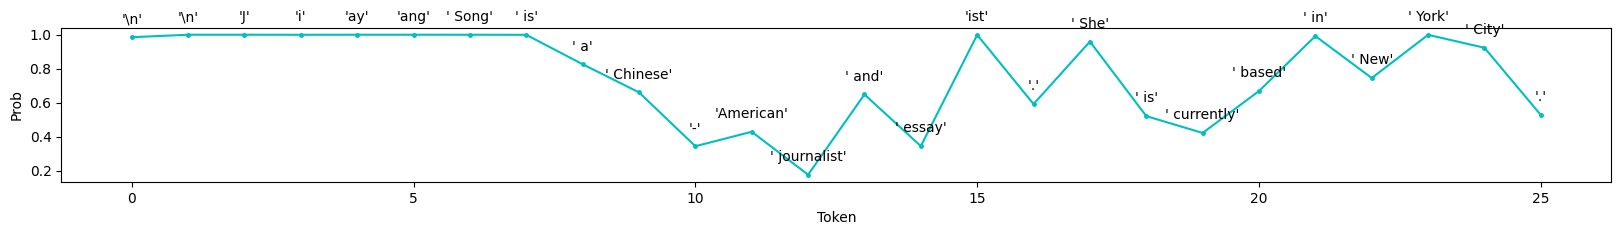

In [12]:
num_token_response = len(top_logprobs)          # num of tokens in response
logprobs = np.zeros([num_token_response, 5])    # array to hold all prob [num_token, top_k_prob]
scores = logprobs.copy()

# tokens in response
token_response = [list(content.keys()) for content in top_logprobs]
token_response = np.array(token_response)

for index, content in enumerate(top_logprobs):
    logprobs[index, :] = np.sort(np.exp(np.array(list(top_logprobs[index].values()))))[::-1]
    scores[index, :] = np.sort(np.array(list(top_logprobs[index].values())))[::-1]
    new_index = np.argsort(np.exp(np.array(list(top_logprobs[index].values()))))[::-1]
    # print(new_index)
    token_response[index, :] = token_response[index, new_index]

# plotting
token_count = np.arange(num_token_response)

plt.figure(figsize=(20, 2))
plt.plot(token_count, logprobs[:,0], marker=".", markersize=5, c="c")
# plt.grid()

# zip joins x and y coordinates in pairs
for x,y in zip(token_count, logprobs[:,0]):

    label = repr(token_response[x,0])
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')   # horizontal alignment can be left, right or center
                 
plt.xlabel("Token")
plt.ylabel("Prob")
print(repr(''.join((token_response[:,0]))))
plt.show()

Output 0: '\n\nJiayang Song is a Chinese-American journalist and essayist. She is currently based in New York City.' 

Output 1: ' J JiaayingagSong ( an professional artistborn writer who writer writer based He currently a a out BrooklynYork,,' 

Output 2: '\n\n Accordingiangayanan song  the software singerCanadian artist based authorists who Her lives based the between Beijing Jersey and and' 

Output 3: '   Jijiyayaeng (, currently fashion actressAustralian entrepreneur, staff- from Born was the an near Los Haven. where' 

Output 4: '   \n\n\nianAYhang Sun was Chinese student professionalBritish singer. a author, Currently has best living on Washington Orleans where but' 



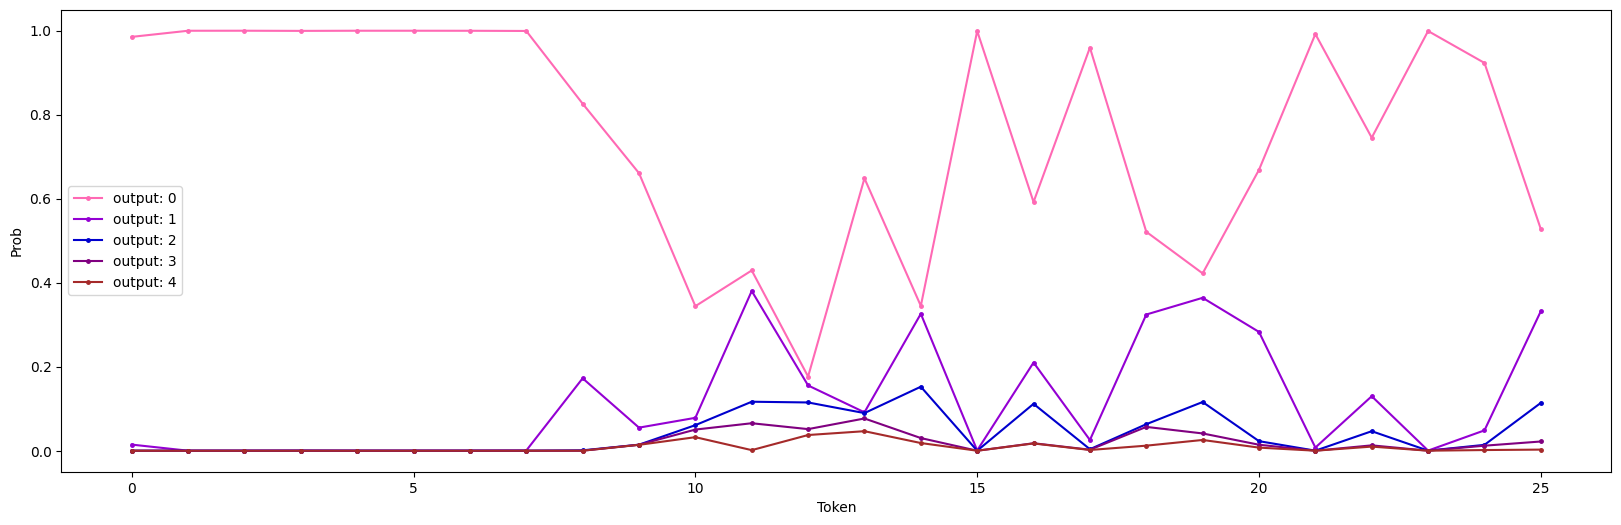

In [13]:
plt.figure(figsize=(20, 6))
plot_colors = ['hotpink','darkviolet','mediumblue', 'purple', 'brown']

for i in range(0,5):
    plt.plot(token_count, logprobs[:,i], marker=".", markersize=5, c=plot_colors[i], label=f"output: {i}")

    print(f"Output {i}: {repr(''.join((token_response[:,i])))} \n")

# plt.grid()

# zip joins x and y coordinates in pairs
# for x,y in zip(token_count, logprobs[:,1]):

#     label = repr(token_response[x,1])
#     plt.annotate(label, # this is the text
#                  (x,y), # these are the coordinates to position the label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center')   # horizontal alignment can be left, right or center

# print(f"{repr(''.join((token_response[:,1])))}")
plt.legend()
plt.xlabel("Token")
plt.ylabel("Prob")
plt.show()

## Dependency parse visualization

In [14]:
nlp = spacy.load("en_core_web_sm")
displacy.render(nlp(text), style='dep', jupyter=True, options={'distance': 120})

## Uncertainty measurement

In [15]:
# supplymnet functions for entropy calculation
def shannon_entropy(problist):
    """Shannon Entropy: negative sum over all probabilities*log2_probabilities
    https://en.wikipedia.org/wiki/Entropy_(information_theory)
    """
    return -1 * sum([prob * log2(prob) for prob in problist])

def nltk_entropy(problist):
    """From nltk.lm: negative average log2_probabilities
    https://www.nltk.org/api/nltk.lm.api.html#nltk.lm.api.LanguageModel.entropy
    """
    return -1 * mean([log2(prob) for prob in problist])

def perplexity(entropy):
    """From nltk.lm: 2**entropy
    This is also a general formula for entropy, not only by NLTK
    https://www.nltk.org/api/nltk.lm.api.html#nltk.lm.api.LanguageModel.perplexity
    """
    return pow(2.0, entropy)

def jurafsky_perplexity(problist):
    """From Jurafsky, Stanford NLP: product of all probabilities** -1/count_of_probabilities
    https://www.youtube.com/watch?v=NCyCkgMLRiY
    """
    probs = [prob for prob in problist]
    return pow(prod(probs), -1/len(probs))

def uncertainty(problist):
    prob_sum =  sum(problist) # just to be sure our total probability mass == 1
    shan_ent = shannon_entropy(problist)
    shan_prplx = perplexity(shan_ent)
    nltk_ent = nltk_entropy(problist)
    nltk_prplx = perplexity(nltk_ent)
    juraf_prplx = jurafsky_perplexity(problist)
    
    # print(
    #     f"Probability sum: {prob_sum}\n\n"
    #     f"Shannon entropy: {shan_ent}\n"
    #     f"Shannon perplexity: {shan_prplx}\n\n"
    #     f"NLTK entropy: {nltk_ent}\n"
    #     f"NLTK perplexity: {nltk_prplx}\n\n"
    #     f"Jurafsky perplexity: {juraf_prplx}")
    return [prob_sum, shan_ent, shan_prplx, nltk_ent, nltk_prplx, juraf_prplx]

In [16]:
answer_uncert = np.zeros([len(logprobs), 6])

# return from uncertainty: [Probability sum, Shannon entropy, Shannon perplexity, 
                            #NLTK entropy, NLTK perplexity, Jurafsky perplexity]
uncer_name = ["Shannon entropy", "Shannon perplexity", 
                            "NLTK entropy", "NLTK perplexity", "Jurafsky perplexity"]
for i in range(0, len(logprobs)):
    answer_uncert[i,:] = uncertainty(logprobs[i,:])

answer_uncert = answer_uncert[:,1:6]

'\n\nJiayang Song is a Chinese-American journalist and essayist. She is currently based in New York City.'


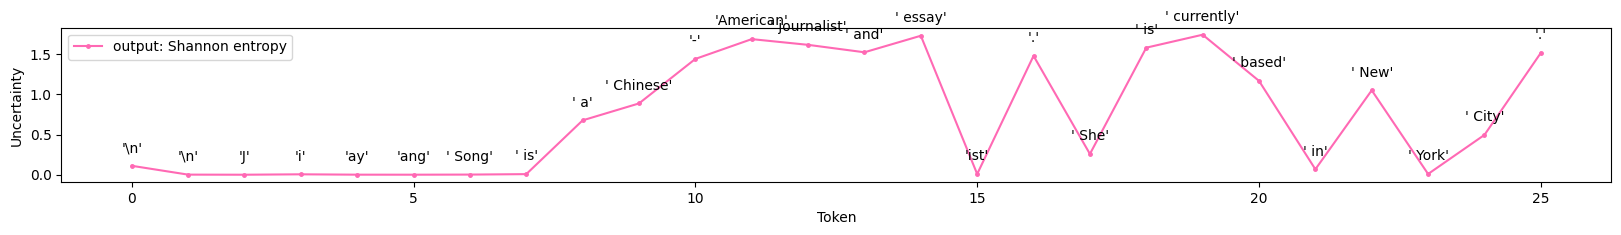

In [17]:
plt.figure(figsize=(20, 2))
plot_colors = ['hotpink','darkviolet','mediumblue', 'purple', 'brown']

for i in range(0,1):
    plt.plot(token_count, answer_uncert[:,i], marker=".", markersize=5, c=plot_colors[i], label=f"output: {uncer_name[i]}")

# zip joins x and y coordinates in pairs
for x,y in zip(token_count, answer_uncert[:,0]):

    label = repr(token_response[x,0])
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')   # horizontal alignment can be left, right or center

print(f"{repr(''.join((token_response[:,0])))}")

plt.legend()
plt.xlabel("Token")
plt.ylabel("Uncertainty")
plt.show()

' J JiaayingagSong ( an professional artistborn writer who writer writer based He currently a a out BrooklynYork,,'


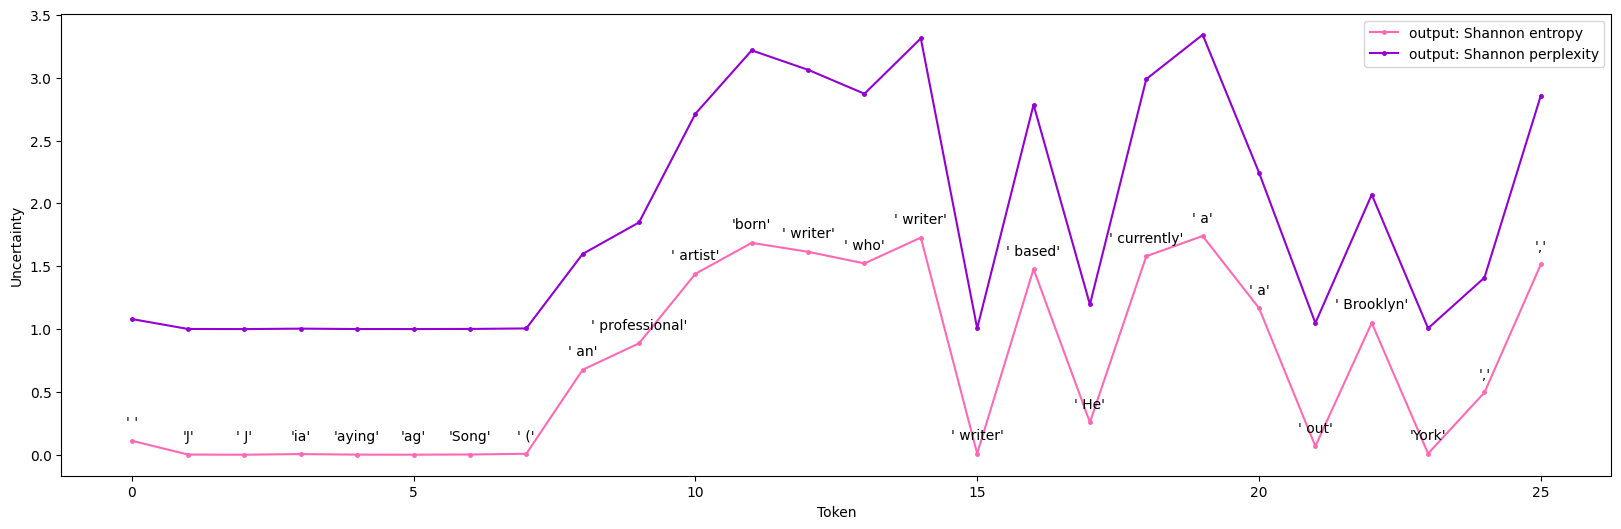

In [18]:
plt.figure(figsize=(20, 6))
plot_colors = ['hotpink','darkviolet','mediumblue', 'purple', 'brown']

for i in range(0,2):
    plt.plot(token_count, answer_uncert[:,i], marker=".", markersize=5, c=plot_colors[i], label=f"output: {uncer_name[i]}")

# zip joins x and y coordinates in pairs
for x,y in zip(token_count, answer_uncert[:,0]):

    label = repr(token_response[x,1])
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')   # horizontal alignment can be left, right or center

print(f"{repr(''.join((token_response[:,1])))}")

plt.legend()
plt.xlabel("Token")
plt.ylabel("Uncertainty")
plt.show()

## Time-aware critieria

1. Time Instance Criteira
> Instance \\
> Instance Top-k 

2. Time Interval Criteria
> Timed \\
> Timed Top-k

3. Time Differential Criteria
> Positve/Negative Differential \\
> Monotonic Increase/Decrease 

### Time-aware probability

In [43]:
# instance prob
h = 0.4     # prob threshold 
instance_prob = logprobs

# timed interval prob
# avg prob per 3 token
window = 3
interval_prob = np.zeros([len(logprobs)-window, 5])

for i in range(0, len(logprobs)-window):
    interval_prob[i,:] = np.mean(logprobs[i:i+window, :], axis=0)

# time differential prob
# differential prob 
diff_prob = logprobs[1:,:] - logprobs[0:-1,:]

# Monotonic within an interval
mono_window = 3 # keep increase/decrease within x tokens
mono_inc_prob = np.zeros([len(logprobs)-mono_window-1, 5])
mono_dec_prob = mono_inc_prob.copy()

for i in range(0, len(mono_inc_prob)):
    mono_inc_prob[i,:] = logprobs[i+mono_window,:] >= logprobs[i,:]
    mono_dec_prob[i,:] = logprobs[i+mono_window,:] < logprobs[i,:]

# zero-padding to keep the length of the passage
res = []
for i in [interval_prob, diff_prob, mono_inc_prob]:
    pad_array = np.zeros([len(token_count)-len(i), 5])
    res.append(np.concatenate((pad_array, i), axis=0))

interval_prob, diff_prob, mono_inc_prob = res

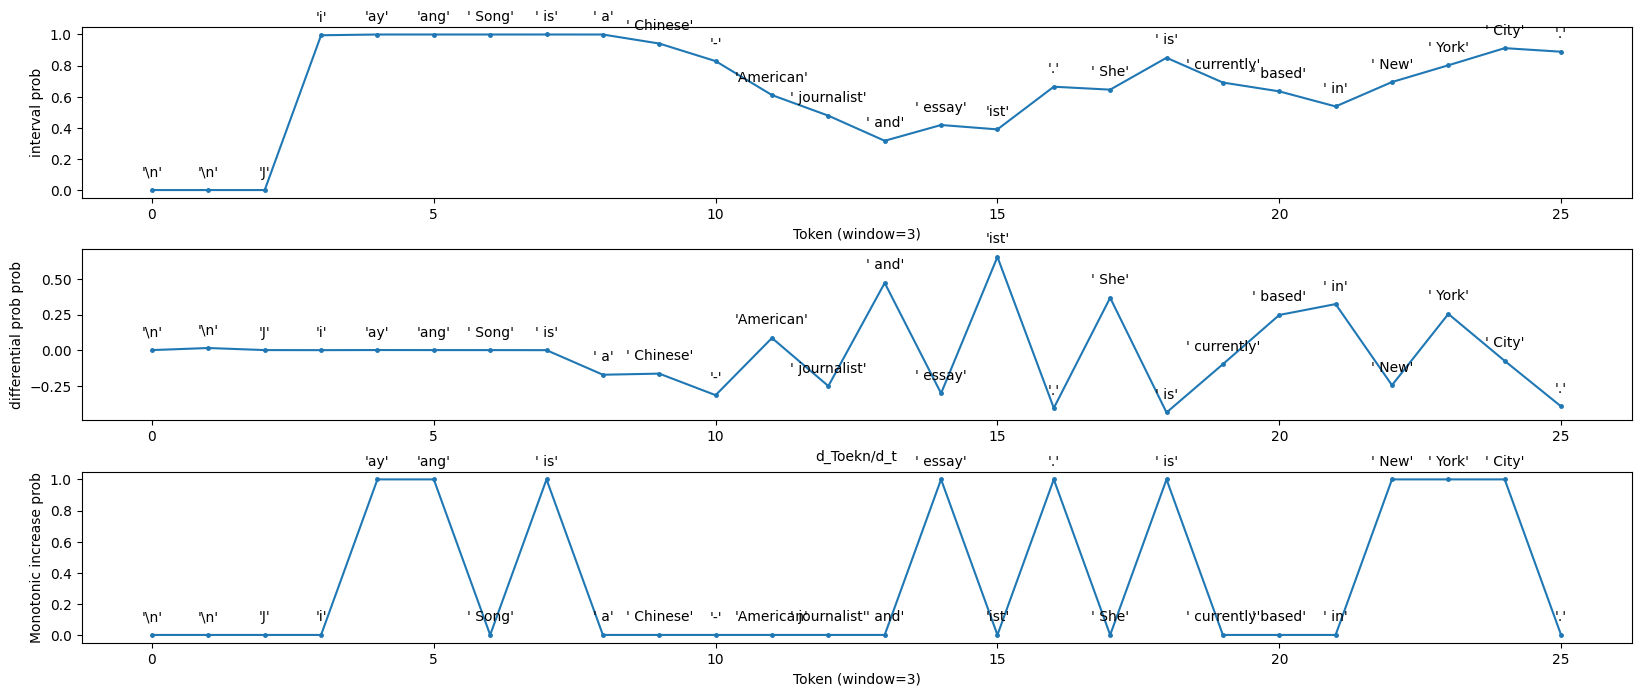

In [60]:
# plotting 
fig, axs = plt.subplots(3, 1, figsize=(20, 8))
label_name = label_name = ["output "+str(i) for i in range(5)]

axs[0].plot(token_count, interval_prob[:,0], marker=".", markersize=5, label=label_name)
axs[0].set_ylabel('interval prob')
axs[0].set_xlabel(f'Token (window={window})')
# axs[0].legend()

axs[1].plot(token_count, diff_prob[:,0], marker=".", markersize=5, label=label_name)
axs[1].set_ylabel('differential prob prob')
axs[1].set_xlabel("d_Toekn/d_t")
# axs[1].legend()

axs[2].plot(token_count, mono_inc_prob[:,0], marker=".", markersize=5, label=label_name)
axs[2].set_ylabel('Monotonic increase prob')
axs[2].set_xlabel(f'Token (window={mono_window})')
# axs[2].legend()

# zip joins x and y coordinates in pairs
for index, value in enumerate([interval_prob, diff_prob, mono_inc_prob]):
    for x,y in zip(token_count, value[:,0]):

        label = repr(token_response[x,0])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center

plt.subplots_adjust(hspace=0.3)
plt.show()

### Time-aware Entropy

In [57]:
# instance entropy
h = 0.4     # entropy threshold 
instance_entropy= answer_uncert

# timed interval entropy
# avg entropy per 3 token
window = 3
instance_entropy = np.zeros([len(answer_uncert)-window, 5])

for i in range(0, len(answer_uncert)-window):
    instance_entropy[i,:] = np.mean(answer_uncert[i:i+window, :], axis=0)

# time differential entropy
# differential entropy 
diff_entropy = answer_uncert[1:,:] - answer_uncert[0:-1,:]

# Monotonic within an interval
mono_window = 3 # keep increase/decrease within x tokens
mono_inc_entropy = np.zeros([len(answer_uncert)-mono_window-1, 5])
mono_dec_entropy = mono_inc_entropy.copy()

for i in range(0, len(mono_inc_entropy)):
    mono_inc_entropy[i,:] = answer_uncert[i+mono_window,:] >= answer_uncert[i,:]
    mono_dec_entropy[i,:] = answer_uncert[i+mono_window,:] < answer_uncert[i,:]

# zero-padding to keep the length of the passage
res = []
for i in [instance_entropy, diff_entropy, mono_inc_entropy]:
    pad_array = np.zeros([len(token_count)-len(i), 5])
    res.append(np.concatenate((pad_array, i), axis=0))

instance_entropy, diff_entropy, mono_inc_entropy = res

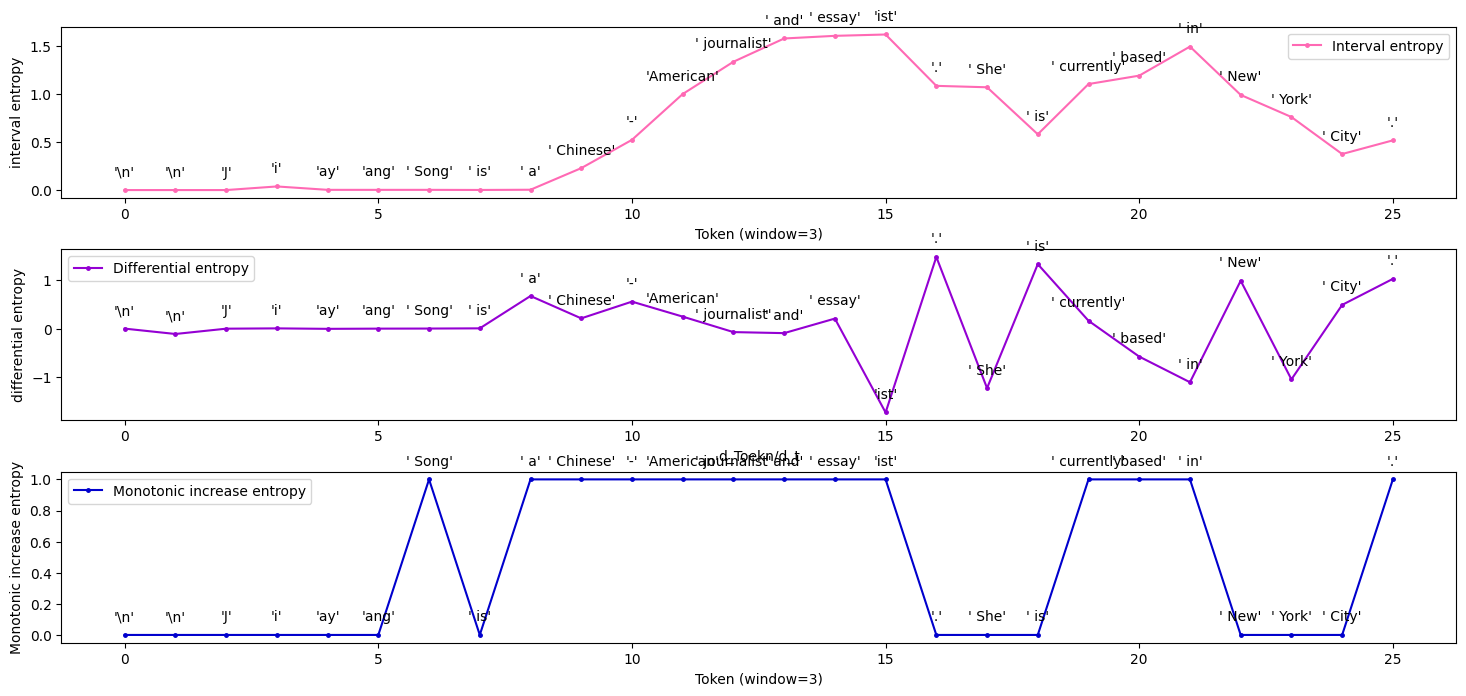

In [68]:
# plotting 
fig, axs = plt.subplots(3, 1, figsize=(18, 8))
label_name = label_name = ["output "+str(i) for i in range(5)]

axs[0].plot(token_count, instance_entropy[:,0], marker=".", markersize=5, label="Interval entropy", c=plot_colors[0])
axs[0].set_ylabel('interval entropy')
axs[0].set_xlabel(f'Token (window={window})')
axs[0].legend()

axs[1].plot(token_count, diff_entropy[:,0], marker=".", markersize=5, label="Differential entropy", c=plot_colors[1])
axs[1].set_ylabel('differential entropy')
axs[1].set_xlabel("d_Toekn/d_t")
axs[1].legend()

axs[2].plot(token_count, mono_inc_entropy[:,0], marker=".", markersize=5, label="Monotonic increase entropy", c=plot_colors[2])
axs[2].set_ylabel('Monotonic increase entropy')
axs[2].set_xlabel(f'Token (window={mono_window})')
axs[2].legend()

# zip joins x and y coordinates in pairs
for index, value in enumerate([instance_entropy, diff_entropy, mono_inc_entropy]):
    for x,y in zip(token_count, value[:,0]):

        label = repr(token_response[x,0])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center

plt.subplots_adjust(hspace=0.3)
plt.show()

## LLM to Finite-State Markov Chain

GPT is a neural net that takes some sequence of discrete tokens and predicts a probabilities for a next token in the sequence. For example, if there are only two tokens 0 and 1, then a tiny little binary GPT could e.g. tell us that:

```
[0,1,0] ---> GPT ---> [P(0) = 20%, P(1) = 80%]
```

Here, GPT took the sequence of bits [0,1,0] and, based on the current setting of parameters, predicted that there is an 80% chance of 1 coming next. Importantly, GPTs by default have a finite context length. For example, if the context length is 3 then they can only take up to 3 tokens at the input. In the case above, if we flip a biased coin and sample that 1 should indeed come next, then we'd transition from the original state [0,1,0] to a new state [1,0,1]. We've added the new bit (1) on the right, and truncated the sequence to the context length 3 by discarding the leftmost bit (0). We can then repeat this process over and over again to transition between states.

Clearly then, GPT is a finite-state markov chain: there is a finite set of states and probabilistic transitions arrows between them. Each state is defined by a specific setting of the token identities at the input to the GPT (e.g. [0,1,0]). And we can transition to new states like [1,0,1] with some probability. Let's see how this works in detail.

The input to the GPT neural net is a sequence of tokens of length `context_length`. These tokens are discrete, so the state space is simply:

**Detail**: To be exact, a GPT can take any number of tokens from 1 to `context_length`. So if the context length is 3, we could in principle feed in 1 token, 2 tokens or 3 tokens, when trying to predict the next token. Here we are going to ignore this and assume that the context length is "maxed out", just to simplify some of the code below, but this is worth keeping in mind.

In [21]:
# hyperparameters for our GPT

# vocab size is 2, so we only have two possible tokens: 0,1
vocab_size = 2
# context length is 3, so we take 3 bits to predict the next bit probability
context_length = 3

print('state space (for this exercise) = ', vocab_size ** context_length)
print('actual state space (in reality) = ', sum(vocab_size ** i for i in range(1, context_length+1)))

state space (for this exercise) =  8
actual state space (in reality) =  14


For this notebook you don't have to worry about `n_layer, n_head, n_embd, bias`, these are just some hyperparameters for the Transformer neural net that implements the GPT.

The parameters of the GPT (12,656 of them) are initialized at random, and they parameterize the transition probabilities between the states. If you smoothly change these parameters, you will smoothly impact the transition probabilities between the states.

Now let's take our randomly initialized GPT for a spin. Let's get all the possible inputs to our little binary GPT with context length of 3:

In [22]:
def all_possible(n, k):
    # return all possible lists of k elements, each in range of [0,n)
    if k == 0:
        yield []
    else:
        for i in range(n):
            for c in all_possible(n, k - 1):
                yield [i] + c
list(all_possible(vocab_size, context_length))

[[0, 0, 0],
 [0, 0, 1],
 [0, 1, 0],
 [0, 1, 1],
 [1, 0, 0],
 [1, 0, 1],
 [1, 1, 0],
 [1, 1, 1]]

In [23]:
#@title minimal GPT implementation in PyTorch (optional)
""" super minimal decoder-only gpt """

import math
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                    .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # manual implementation of attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.nonlin = nn.GELU()

    def forward(self, x):
        x = self.c_fc(x)
        x = self.nonlin(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    # these are default GPT-2 hyperparameters
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    bias: bool = False

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %d" % (sum(p.nelement() for p in self.parameters()),))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x[:, -1, :]) # note: only returning logits at the last time step (-1), output is 2D (b, vocab_size)
        return logits



In [24]:
config = GPTConfig(
    block_size = context_length,
    vocab_size = vocab_size,
    n_layer = 4,
    n_head = 4,
    n_embd = 16,
    bias = False,
)
gpt = GPT(config)

number of parameters: 12656


These 8 possibilities are the 8 possible states the GPT can be in. So let's run the GPT on every one of these possible token sequence and get the probabilities of the next token in the sequence, and plot as a pretty graph:

input [0, 0, 0] ---> [0.4963349997997284, 0.5036649107933044]
input [0, 0, 1] ---> [0.4515703618526459, 0.5484296679496765]
input [0, 1, 0] ---> [0.49648362398147583, 0.5035163760185242]
input [0, 1, 1] ---> [0.45181113481521606, 0.5481888651847839]
input [1, 0, 0] ---> [0.4961162209510803, 0.5038837194442749]
input [1, 0, 1] ---> [0.4517717957496643, 0.5482282042503357]
input [1, 1, 0] ---> [0.4962802827358246, 0.5037197470664978]
input [1, 1, 1] ---> [0.4520467519760132, 0.5479532480239868]


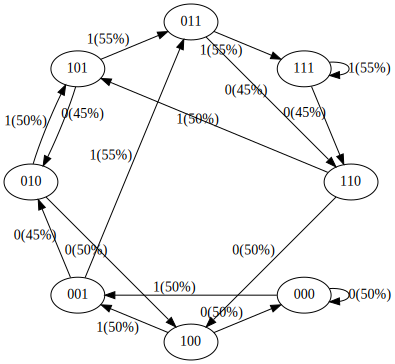

In [25]:
# we'll use graphviz for pretty plotting the current state of the GPT
from graphviz import Digraph

def plot_model():
    dot = Digraph(comment='Baby GPT', engine='circo')

    for xi in all_possible(gpt.config.vocab_size, gpt.config.block_size):
        
        # forward the GPT and get probabilities for next token
        x = torch.tensor(xi, dtype=torch.long)[None, ...] # turn the list into a torch tensor and add a batch dimension
        logits = gpt(x) # forward the gpt neural net
        probs = nn.functional.softmax(logits, dim=-1) # get the probabilities
        y = probs[0].tolist() # remove the batch dimension and unpack the tensor into simple list
        print(f"input {xi} ---> {y}")

        # also build up the transition graph for plotting later
        current_node_signature = "".join(str(d) for d in xi)
        dot.node(current_node_signature)
        for t in range(gpt.config.vocab_size):
            next_node = xi[1:] + [t] # crop the context and append the next character
            next_node_signature = "".join(str(d) for d in next_node)
            p = y[t]
            label=f"{t}({p*100:.0f}%)"
            dot.edge(current_node_signature, next_node_signature, label=label)
    
    return dot

plot_model()

We see our 8 states, and the probabilistic arrows that connect them. Because there are 2 possible tokens, there are 2 possible arrows coming out of each node. Note that every time we "transition" via an edge, the leftmost token gets dropped, and the token on that edge gets appended to the right. Notice that at initialization, most of these probabilities are around uniform (50% in this case), which is nice and desirable, as we haven't even trained the model at all. 

Let's do that now:

In [26]:
# let's train our baby GPT on this sequence
seq = list(map(int, "111101111011110"))

# convert the sequence to a tensor holding all the individual examples in that sequence
X, Y = [], []
# iterate over the sequence and grab every consecutive 3 bits
# the correct label for what's next is the next bit at each position
for i in range(len(seq) - context_length):
    X.append(seq[i:i+context_length])
    Y.append(seq[i+context_length])
    print(f"example {i+1:2d}: {X[-1]} --> {Y[-1]}")
X = torch.tensor(X, dtype=torch.long)
Y = torch.tensor(Y, dtype=torch.long)
print(X.shape, Y.shape)

example  1: [1, 1, 1] --> 1
example  2: [1, 1, 1] --> 0
example  3: [1, 1, 0] --> 1
example  4: [1, 0, 1] --> 1
example  5: [0, 1, 1] --> 1
example  6: [1, 1, 1] --> 1
example  7: [1, 1, 1] --> 0
example  8: [1, 1, 0] --> 1
example  9: [1, 0, 1] --> 1
example 10: [0, 1, 1] --> 1
example 11: [1, 1, 1] --> 1
example 12: [1, 1, 1] --> 0
torch.Size([12, 3]) torch.Size([12])


We see that we have 12 examples in that one sequence. Let's train it now:

In [27]:
# init a GPT and the optimizer
torch.manual_seed(1337)
gpt = GPT(config)
optimizer = torch.optim.AdamW(gpt.parameters(), lr=1e-3, weight_decay=1e-1)

number of parameters: 12656


In [28]:
# train the GPT for some number of iterations
for i in range(50):
    logits = gpt(X)
    loss = F.cross_entropy(logits, Y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(i, loss.item())

0 0.663539469242096
1 0.6393510103225708
2 0.6280076503753662
3 0.6231870055198669
4 0.6198631525039673
5 0.6163331270217896
6 0.6124278903007507
7 0.6083487868309021
8 0.6043017506599426
9 0.6004215478897095
10 0.5967749953269958
11 0.5933789610862732
12 0.5902208685874939
13 0.5872761011123657
14 0.5845204591751099
15 0.5819371342658997
16 0.5795179009437561
17 0.5772626996040344
18 0.5751749873161316
19 0.5732589960098267
20 0.5715171694755554
21 0.5699482560157776
22 0.5685476660728455
23 0.5673080086708069
24 0.5662192106246948
25 0.5652689337730408
26 0.5644428730010986
27 0.563723087310791
28 0.5630872845649719
29 0.5625078678131104
30 0.5619534254074097
31 0.5613844990730286
32 0.5607481598854065
33 0.5599767565727234
34 0.5589826107025146
35 0.5576505064964294
36 0.5558211803436279
37 0.5532580018043518
38 0.5495675802230835
39 0.5440602898597717
40 0.5359978079795837
41 0.5282725095748901
42 0.5195847153663635
43 0.5095029473304749
44 0.5019271969795227
45 0.49031805992126465

Training data sequence, as a reminder: [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]
input [0, 0, 0] ---> [0.2683657109737396, 0.7316343188285828]
input [0, 0, 1] ---> [0.21858924627304077, 0.7814106941223145]
input [0, 1, 0] ---> [0.24217553436756134, 0.7578244805335999]
input [0, 1, 1] ---> [0.20438867807388306, 0.7956112623214722]
input [1, 0, 0] ---> [0.252511203289032, 0.747488796710968]
input [1, 0, 1] ---> [0.20714525878429413, 0.7928547859191895]
input [1, 1, 0] ---> [0.2200900763273239, 0.7799099087715149]
input [1, 1, 1] ---> [0.5463876128196716, 0.45361238718032837]


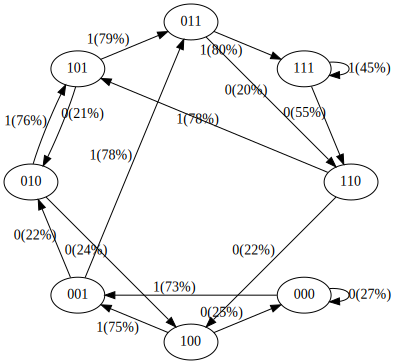

In [29]:
print("Training data sequence, as a reminder:", seq)
plot_model()

Nice! the arrows that correspond to transitions in our training data get higher probabilities. That makes sense. For example:

- In our training data 101 always transitions to 011. After 50 steps of training, we see that this transition has 79% probability.
- In our training data 111 goes to 111 50% of time, and 110 50% of the time, and this is almost exactly what we see in our model (45% and 55% respectively).

We don't get exactly 100% or 50% probability for these arrows because the network wasn't fully trained, but you'd expect to get close if you continue training.

Note something else that is interesting: some of the states that never appeared in the training data (e.g. 000 or 100) have substantial probabilities for what tokens should come next. If these states were never encountered during training, shouln't their outbound arrows be at ~50%? You'd think this was a bug, but actually this is desirable because in a real application scenario during deployment, almost every test input to the GPT is a never-before-seen input during training. We rely on the internals of the GPT (and its "inductive bias") to perform the generalization appropriately.

Finally, let's sample from this GPT:

In [30]:
xi = [1, 1, 1] # the starting sequence
fullseq = xi.copy()
print(f"init: {xi}")
for k in range(20):
    x = torch.tensor(xi, dtype=torch.long)[None, ...]
    logits = gpt(x)
    probs = nn.functional.softmax(logits, dim=-1)
    t = torch.multinomial(probs[0], num_samples=1).item() # sample from the probability distribution
    xi = xi[1:] + [t] # transition to the next state
    fullseq.append(t)
    print(f"step {k}: state {xi}")

print("\nfull sampled sequence:")
print("".join(map(str, fullseq)))

init: [1, 1, 1]
step 0: state [1, 1, 0]
step 1: state [1, 0, 1]
step 2: state [0, 1, 1]
step 3: state [1, 1, 1]
step 4: state [1, 1, 0]
step 5: state [1, 0, 1]
step 6: state [0, 1, 1]
step 7: state [1, 1, 1]
step 8: state [1, 1, 0]
step 9: state [1, 0, 1]
step 10: state [0, 1, 1]
step 11: state [1, 1, 0]
step 12: state [1, 0, 1]
step 13: state [0, 1, 1]
step 14: state [1, 1, 1]
step 15: state [1, 1, 1]
step 16: state [1, 1, 0]
step 17: state [1, 0, 1]
step 18: state [0, 1, 0]
step 19: state [1, 0, 1]

full sampled sequence:
11101110111011011110101


Nice! the arrows that correspond to transitions in our training data get higher probabilities. That makes sense. For example:

- In our training data 101 always transitions to 011. After 50 steps of training, we see that this transition has 79% probability.
- In our training data 111 goes to 111 50% of time, and 110 50% of the time, and this is almost exactly what we see in our model (45% and 55% respectively).

We don't get exactly 100% or 50% probability for these arrows because the network wasn't fully trained, but you'd expect to get close if you continue training.

Note something else that is interesting: some of the states that never appeared in the training data (e.g. 000 or 100) have substantial probabilities for what tokens should come next. If these states were never encountered during training, shouln't their outbound arrows be at ~50%? You'd think this was a bug, but actually this is desirable because in a real application scenario during deployment, almost every test input to the GPT is a never-before-seen input during training. We rely on the internals of the GPT (and its "inductive bias") to perform the generalization appropriately.

Finally, let's sample from this GPT:

number of parameters: 12656
input [0, 0] ---> [0.4023578464984894, 0.3247871398925781, 0.2728550136089325]
input [0, 1] ---> [0.3112931251525879, 0.41417476534843445, 0.27453210949897766]
input [0, 2] ---> [0.29536890983581543, 0.30436983704566956, 0.400261253118515]
input [1, 0] ---> [0.4040412902832031, 0.32429811358451843, 0.2716606557369232]
input [1, 1] ---> [0.3113819658756256, 0.4152715802192688, 0.2733464539051056]
input [1, 2] ---> [0.29491397738456726, 0.302636981010437, 0.40244901180267334]
input [2, 0] ---> [0.40355363488197327, 0.3235832452774048, 0.27286314964294434]
input [2, 1] ---> [0.31285664439201355, 0.41349685192108154, 0.2736465036869049]
input [2, 2] ---> [0.29775166511535645, 0.30284032225608826, 0.3994080722332001]


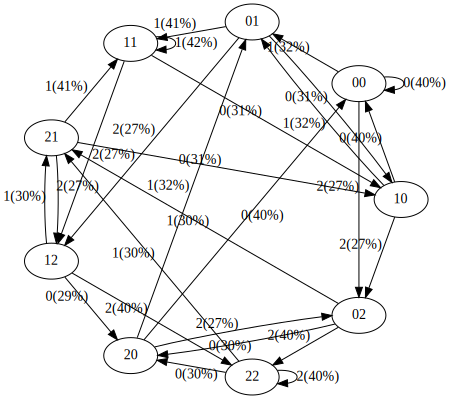

In [31]:
config = GPTConfig(
    block_size = 2,
    vocab_size = 3,
    n_layer = 4,
    n_head = 4,
    n_embd = 16,
    bias = False,
)
gpt = GPT(config)
plot_model()